# The Zero Order Hold trajectory leg

The zero order hold trajectory leg is implemented in `pykep` in the class {class}`pykep.leg.zoh`. Extending the concept of segments we find in the {class}`pykep.leg.sims_flanagan`, this leg accounts for a continuous thrust considered fixed in some frame along each segment of predefined length.

It thus approximates a thrust strategy via a sequence of continuous, constant thrust arcs (zero order hold). The leg is defined by a starting state $\mathbf x_s = [\mathbf r_s, \mathbf v_s, m_s]$, a final state $\mathbf x_f = [\mathbf r_f, \mathbf v_f, m_f]$ and a time grid defining the various segment lengths.

A sequence of controls $\mathbf u = [T_0, i_{x0}, i_{y0}, i_{z0}, T_1, i_{x1}, i_{y1}, i_{z1}, T_2, i_{x2}, i_{y2}, i_{z2}, ... ]$ define the magnitude and direction of the continuous thrust vector along each segment).

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.zoh` efficiently.

We start with some imports:

In [1]:
import pykep as pk
import heyoka as hy
import numpy as np
import pygmo as pg

%matplotlib ipympl

In [126]:
# The integrators (Keplerian Propagation in Cartesian)
tol=1e-14
tol_var = 1e-14

ta_global = pk.ta.get_zoh_kep(tol)
ta_var_global = pk.ta.get_zoh_kep_var(tol_var)

# We test the zero hold leg

In [127]:
# To compute numerical gradients its convenientto have this API
def compute_mismatch_constraints_n(leg, state0, controls, state1, tgrid):
   leg.tgrid = tgrid
   leg.state0 = state0
   leg.state1 = state1
   leg.controls = controls
   leg.state1 = state1
   return leg.compute_mismatch_constraints()

In [134]:
# We create a ballistic leg 
t0 = 10000
t1 = 10400
pl0 = pk.planet(pk.udpla.jpl_lp("Earth"))
pl1 = pk.planet(pk.udpla.jpl_lp("Mars"))
r0, v0 = pl0.eph(t0)
r1, v1 = pl1.eph(t1)
# We create some starting conditions from a Lambert arc
l = pk.lambert_problem(r0=r0, r1=r1, tof = (t1-t0) * pk.DAY2SEC, mu = pk.MU_SUN)
m0 = 1000
m1 = 1000


# Instantiate the leg 
# nd units
L = pk.AU
MU = pk.MU_SUN
TIME = np.sqrt(L**3/MU)
V =  L/TIME
ACC = V/TIME
MASS = 1000
F = MASS*ACC

# leg data
nseg = int(np.random.uniform(4, 20))
veff = np.random.uniform(4000, 8000) * pk.G0

# nd data
state0 = [it/L for it in r0] + [it/V for it in l.v0[0]] + [m0/MASS]
state1 = [it/L for it in r1] + [it/V for it in l.v1[0]] + [m1/MASS]
veff_nd = veff / V
tgrid = np.linspace(t0*pk.DAY2SEC/TIME, t1*pk.DAY2SEC/TIME, nseg+1)

uixiyiz = np.random.uniform(-1,1, (4*nseg,))

cut = np.random.uniform(0,1)

ta_global.pars[4] = 1. / veff_nd
ta_var_global.pars[4] = 1. / veff_nd

leg = pk.leg.zoh(state0, uixiyiz.tolist(), state1, tgrid, cut = cut, tas = [ta_global, ta_var_global])
leg_dummy = pk.leg.zoh(state0, uixiyiz.tolist(), state1, tgrid, cut = cut, tas = [ta_global, ta_var_global])


In [139]:
# Chack on dmc/dx0
grad_an = leg.compute_mc_grad()[0]
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_dummy, x, leg_dummy.controls, leg_dummy.state1, leg_dummy.tgrid), leg.state0, dx=1e-4).reshape(7,-1)
np.linalg.norm(grad_num-grad_an)

2.838948354887493e-08

In [140]:
# Chack on dmc/dxf
grad_an = leg.compute_mc_grad()[1]
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_dummy, leg_dummy.state0, leg_dummy.controls, x, leg_dummy.tgrid), leg.state1, dx=1e-4).reshape(7,-1)
np.linalg.norm(grad_num-grad_an)

3.2273134295019047e-07

In [146]:
# Chack on dmc/dcontrols
grad_an = leg.compute_mc_grad()[2]
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_dummy, leg_dummy.state0, x, leg_dummy.state1, leg_dummy.tgrid), leg.controls, dx=1E-9).reshape(7,-1)
np.linalg.norm(grad_num-grad_an)

0.00068025381521811873

In [124]:
grad_an = leg.compute_mc_grad()[3]
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_dummy, leg_dummy.state0, leg_dummy.controls, leg_dummy.state1, x), leg.tgrid).reshape(7,-1)
np.linalg.norm(grad_num-grad_an)

1.6082462755433045e-06

Now the gradient is always well defined, non nans:

In [10]:
leg = pk.leg.zoh(state0, [0.1,0.2,0.3,0.4]*6, state1, np.linspace(0,400, 7)*pk.DAY2SEC/TIME, cut = cut, tas = [ta_global, ta_var_global])
dmcdx0, dmcdu, dmcdxf, dmdtgrid = leg.compute_mc_grad()
dmcdu

array([[ -4.47225948e+00,  -3.75471325e+00,  -2.80425008e-01,
          9.66083284e+00,   2.23980317e+00,   7.95323374e-01,
          3.45452860e-01],
       [ -1.40727317e+00,  -7.79382084e-01,  -6.48136368e-02,
          7.75923669e-01,   3.17404327e+00,   1.74257954e-02,
          2.17571935e-01],
       [ -5.85173611e-01,  -4.30822029e-01,   4.27517277e-01,
          1.03059063e+00,   2.49418237e-01,   2.61261951e+00,
          3.08390284e-01],
       [  1.93519496e+00,   1.77477969e+00,   1.23877424e-01,
         -4.59087996e+00,  -8.13999385e-01,  -6.46640286e-01,
         -1.93575858e-01],
       [ -2.96776540e-01,  -6.51428882e-01,  -9.47920577e-03,
          8.30189734e-01,   1.54974751e-01,   1.39111911e-01,
         -3.03463903e-02],
       [  4.46480650e-01,   3.53086107e-01,  -3.55635414e-01,
         -9.60664084e-01,  -1.39291720e-01,  -7.25197846e-03,
         -1.12153659e-01],
       [ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         -0.00000000e+00,  -0.00

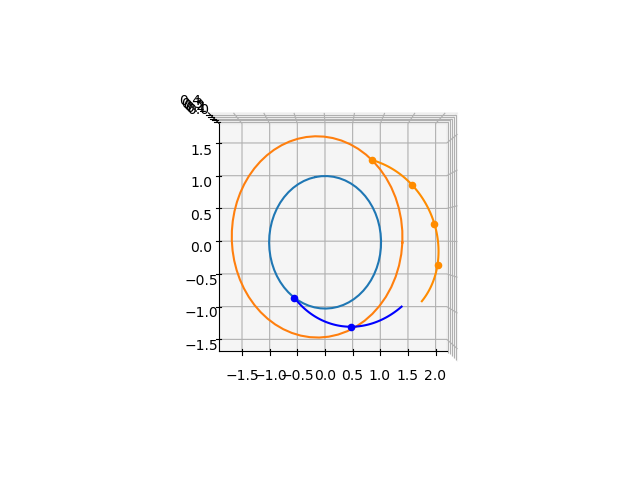

In [15]:
ax = pk.plot.make_3Daxis()
pk.plot.add_planet_orbit(ax, pl0, units=pk.AU)
pk.plot.add_planet_orbit(ax, pl1, units=pk.AU)
fwd, bck = leg.get_state_info(N=100)
for segment in fwd:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'blue') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'blue') 
for segment in bck:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'darkorange') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'darkorange') 

ax.view_init(90,-90)


In [16]:
def numtc(x):
    leg.controls = x
    return leg.compute_throttle_constraints()
numtc(leg.controls)

[-0.71, -0.71, -0.71, -0.71, -0.71, -0.71]

In [17]:
pg.estimate_gradient(numtc, leg.controls).reshape(leg.nseg,-1)

array([[ 0.        ,  0.4       ,  0.59999999,  0.8       ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.4       ,  0.59999999,  0.8       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.4       ,
         0.59999999,  0.8       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
  

In [18]:
leg.compute_tc_grad()

array([[ 0.        ,  0.4       ,  0.6       ,  0.8       ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.4       ,  0.6       ,  0.8       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.4       ,
         0.6       ,  0.8       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
  

In [19]:
type(leg.compute_mismatch_constraints())

list

In [20]:
import numpy as np
import pykep as pk

# The integrators (Keplerian Propagation in Cartesian)
tol=1e-12
tol_var = 1e-6
ta_global = pk.ta.get_zoh_kep(tol)
ta_var_global = pk.ta.get_zoh_kep_var(tol_var)

# We create a ballistic leg 
t0 = 10000 # MJD2000
t1 = 10400 # MJD2000
pl0 = pk.planet(pk.udpla.jpl_lp("Earth"))
pl1 = pk.planet(pk.udpla.jpl_lp("Mars"))
r0, _ = pl0.eph(t0)
r1, _ = pl1.eph(t1)
l = pk.lambert_problem(r0=r0, r1=r1, tof = (t1-t0) * pk.DAY2SEC, mu = pk.MU_SUN)
m0 = 1000
m1 = 1000

# nd units (in these units mu must be one as to use the tas)
L = pk.AU
MU = pk.MU_SUN
TIME = np.sqrt(L**3/MU)
V =  L/TIME
ACC = V/TIME
MASS = 1000
F = MASS*ACC

# We instantiate a ballistic leg and test for small mismatches
n_trials = 50
for i in range(n_trials):
    # leg data
    nseg = int(np.random.uniform(4, 20))
    veff = np.random.uniform(2000, 7000) * pk.G0

    # nd construction data
    state0 = [it/L for it in r0] + [it/V for it in l.v0[0]] + [m0/MASS]
    state1 = [it/L for it in r1] + [it/V for it in l.v1[0]] + [m1/MASS]
    veff_nd = veff / V
    tgrid = np.linspace(t0*pk.DAY2SEC/TIME, t1*pk.DAY2SEC/TIME, nseg+1)
    controls = np.random.uniform(-1,1, (4*nseg,)) * 1e-3
    controls[0::4] = 0 # zeroing the thrust magnitude
    cut = np.random.uniform(0,1)
    ta_global.pars[4] = 1. / veff_nd
    ta_var_global.pars[4] = 1. / veff_nd
    # construct the leg
    leg = pk.leg.zoh(state0, controls.tolist(), state1, tgrid, cut = cut, tas = [ta_global, ta_var_global])
    # test
    mc = leg.compute_mismatch_constraints()

In [21]:
mc

[1.199040866595169e-13,
 -4.363176486776865e-14,
 1.2601031329495527e-14,
 7.05546732149287e-14,
 4.440892098500626e-15,
 5.752343046339092e-15,
 0.0]